<a href="https://colab.research.google.com/github/TNK443/RecPadroes/blob/main/04_ArvoreDeDecisao_Tarefa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Heurística para escolher o melhor valor de cada característica**

Crie a sua heurística para escolher a melhor característica para um nó de uma árvore de decisão e compare com a implementação feita nos vídeos postados nesse tópico aqui no AVA e com a implementação do scikit learn.

Faça comparações plotando as regiões de decisão com resubstituição para a base iris e as características usadas nos vídeos.

Também faça comparações usando validação cruzada com pelo menos 3 bases de classificação com atributos contínuos.

Escreva um parágrafo expondo sua interpretação dos resultados obtidos.

### Bibliotecas

In [1]:
#---------------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import statistics

from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
from sklearn.model_selection import cross_validate
#---------------------------------------------------------------------------------

### Carregando a Base IRIS

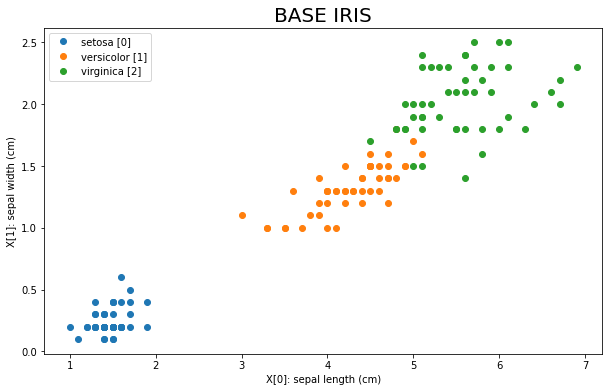

In [2]:
#---------------------------------------------------------------------------------
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data[:,2:], iris.target

plt.figure(figsize=(10,6))
plt.title('BASE IRIS', fontsize=20)

for k in sorted(set(y)):
    plt.plot(X[:, 0][y==k], X[:, 1][y==k], 'o', 
             label=f"{iris.target_names[k]} [{k}]")


plt.legend()
plt.xlabel(f"X[0]: {iris.feature_names[0]}")
plt.ylabel(f"X[1]: {iris.feature_names[1]}")
plt.show()
#---------------------------------------------------------------------------------

### IMPUREZA

In [3]:
#---------------------------------------------------------------------------------
def impureza(y): #Gini
    labels = list(set(y))                       # lista com labels únicos do y
    labels.sort()                               # ordernar dá uma garantia de que a lista sempre vai estar na mesma sequência.
    probabilidades = np.zeros((len(labels),))   # probabilidade de cada caracteristica/label de estar mais puro que os demais.
    for i,k in enumerate(labels):               # passa por todos os labels
        probabilidades[i] = sum(y==k)/len(y)    # A probabilidade de Label ocorrer.
    result = 1 - sum(probabilidades**2)         # A Gini eleva essa probabilidade ao quadrado.
    return result


ytmp = y[:]
valor = impureza(ytmp)

print('-'*60)
print()
print("Impureza_GINI(y)=", valor)
print()
print('-'*60)
#---------------------------------------------------------------------------------

------------------------------------------------------------

Impureza_GINI(y)= 0.6666666666666667

------------------------------------------------------------


In [4]:
#---------------------------------------------------------------------------------
def impurezaValor(x, y, valor):
    # MAIORES que o valor
    maiores = x > valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    # MENORES que o valor
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)

    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores

    return impurezaTotal, impurezaMaiores, impurezaMenores

# Impureza de uma Valor determinado
# impurezaValor(X[:,0], y, 2)
print('-'*60)
print()
print("Impureza(Maior|Menor) do Valor '2' =", impurezaValor(X[:,0],y,2)[0])
print()
print('-'*60)
#---------------------------------------------------------------------------------

------------------------------------------------------------

Impureza(Maior|Menor) do Valor '2' = 0.3333333333333333

------------------------------------------------------------


In [5]:
#---------------------------------------------------------------------------------
def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]
#---------------------------------------------------------------------------------

In [6]:
# ----------------------------------------------------------------------------------------------------

## Crie a sua heurística para escolher a melhor característica para um nó de uma árvore de decisão e compare com a implementação feita nos vídeos postados nesse tópico aqui no AVA e com a implementação do scikit learn.

### Heurística Padrão dado em AULA.

In [7]:
#---------------------------------------------------------------------------------
def melhorValor_HPadrao(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)

    while True:
        valor = (xmax+xmin)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza

aux1, aux2 = melhorValor_HPadrao(X[:,0], y)

print('='*60)
#      ============================================================
print("                    melhorValor_HPadrao                    ")
print('='*60)
print('-'*60)
print()
print("Result =",aux1)
print("menorImpureza =",aux2)
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                    melhorValor_HPadrao                    
------------------------------------------------------------

Result = 2.475
menorImpureza = 0.3333333333333333

------------------------------------------------------------


In [8]:
#---------------------------------------------------------------------------------
def melhorCaracteristica_HPadrao(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor_HPadrao(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)    
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)

    return caracteristica, valores[caracteristica], impurezas[caracteristica]

aux1, aux2, aux3 = melhorCaracteristica_HPadrao(X,y)

print('='*60)
#      ============================================================
print("                melhorCaracteristica_HPadrao                ")
print('='*60)
print('-'*60)
print()
print("Caracteristica =",aux1)
print("Valores[caracteristica] =",aux2)
print("Impurezas[caracteristica] =",aux3)
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                melhorCaracteristica_HPadrao                
------------------------------------------------------------

Caracteristica = 0
Valores[caracteristica] = 2.475
Impurezas[caracteristica] = 0.3333333333333333

------------------------------------------------------------


In [9]:
#---------------------------------------------------------------------------------
class Arvore_A(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica_HPadrao(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore_A()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore_A()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores]  = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])

        return y

modelo_A = Arvore_A()
modelo_A.fit(X,y)
ypred_A = modelo_A.predict(X)

print('='*60)
#      ============================================================
print("                 Arvore_A: Definido na AULA                 ")
print('='*60)
print('-'*60)
print()
print("Accuracy Score =", accuracy_score(y, ypred_A))
print("Matriz_Acerto:")
print((ypred_A == y))
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                 Arvore_A: Definido na AULA                 
------------------------------------------------------------

Accuracy Score = 0.9933333333333333
Matriz_Acerto:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  Tru

### Heurística 01 Criada: Porém não houve melhoras, usando a base Iris.

In [10]:
#---------------------------------------------------------------------------------
def melhorValor_HPior(x, y):
    result = None
    menorImpureza = float('inf')

    while True:
        valor = np.median(x)
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza

aux1, aux2 = melhorValor_HPior(X[:,0], y)

print('='*60)
#      ============================================================
print("                     melhorValor_HPipor                     ")
print('='*60)
print('-'*60)
print()
print("Result =",aux1)
print("menorImpureza =",aux2)
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                     melhorValor_HPipor                     
------------------------------------------------------------

Result = 4.35
menorImpureza = 0.4444444444444444

------------------------------------------------------------


In [11]:
#---------------------------------------------------------------------------------
def melhorCaracteristica_HPior(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor_HPior(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)    
    
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)

    return caracteristica, valores[caracteristica], impurezas[caracteristica]

aux1, aux2, aux3 = melhorCaracteristica_HPior(X,y)

print('='*60)
#      ============================================================
print("                 melhorCaracteristica_HPior                 ")
print('='*60)
print('-'*60)
print()
print("Caracteristica =",aux1)
print("Valores[caracteristica] =",aux2)
print("Impurezas[caracteristica] =",aux3)
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                 melhorCaracteristica_HPior                 
------------------------------------------------------------

Caracteristica = 1
Valores[caracteristica] = 1.3
Impurezas[caracteristica] = 0.44301994301994296

------------------------------------------------------------


In [12]:
#---------------------------------------------------------------------------------
class Arvore_B(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica_HPior(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore_B()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore_B()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores]  = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo_B = Arvore_B()
modelo_B.fit(X,y)
ypred_B = modelo_B.predict(X)
accuracy_score(y, ypred_B), (ypred_B == y)

print('='*60)
#      ============================================================
print("                  Arvore_B: Heurística 01                   ")
print('='*60)
print('-'*60)
print()
print("Accuracy Score =", accuracy_score(y, ypred_A))
print("Matriz_Acerto:")
print((ypred_A == y))
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                  Arvore_B: Heurística 01                   
------------------------------------------------------------

Accuracy Score = 0.9933333333333333
Matriz_Acerto:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  Tru

### Heurística 02 Criada: Com um pequeno ajuste, afetando um pouca a melhora do np.mean(scores['test_score']), usando a base Iris.

In [13]:
#---------------------------------------------------------------------------------
def melhorValor_HBestScore(x, y):
    result = None
    menorImpureza = float('inf')

    while True:
        xmax = np.max(x)
        xmin = np.min(x)
        valor = (xmax+xmin)/2

        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza

aux1, aux2 = melhorValor_HBestScore(X[:,0], y)

print('='*60)
#      ============================================================
print("                   melhorValor_HBestScore                   ")
print('='*60)
print('-'*60)
print()
print("Result =",aux1)
print("menorImpureza =",aux2)
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                   melhorValor_HBestScore                   
------------------------------------------------------------

Result = 3.95
menorImpureza = 0.41235341069564685

------------------------------------------------------------


In [14]:
#---------------------------------------------------------------------------------
def melhorCaracteristica_HBestScore(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor_HBestScore(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)    
    
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)

    return caracteristica, valores[caracteristica], impurezas[caracteristica]

aux1, aux2, aux3 = melhorCaracteristica_HBestScore(X,y)

print('='*60)
#      ============================================================
print("              melhorCaracteristica_HBestScore               ")
print('='*60)
print('-'*60)
print()
print("Caracteristica =",aux1)
print("Valores[caracteristica] =",aux2)
print("Impurezas[caracteristica] =",aux3)
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

              melhorCaracteristica_HBestScore               
------------------------------------------------------------

Caracteristica = 0
Valores[caracteristica] = 3.95
Impurezas[caracteristica] = 0.41235341069564685

------------------------------------------------------------


In [15]:
#---------------------------------------------------------------------------------
class Arvore_C(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica_HBestScore(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore_C()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore_C()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores]  = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])

        return y

modelo_C = Arvore_C()
modelo_C.fit(X,y)
ypred_C = modelo_C.predict(X)
accuracy_score(y, ypred_C), (ypred_C == y)

print('='*60)
#      ============================================================
print("                  Arvore_C: Heurística 02                   ")
print('='*60)
print('-'*60)
print()
print("Accuracy Score =", accuracy_score(y, ypred_A))
print("Matriz_Acerto:")
print((ypred_A == y))
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                  Arvore_C: Heurística 02                   
------------------------------------------------------------

Accuracy Score = 0.9933333333333333
Matriz_Acerto:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  Tru

### Heurística 03 Criada: Não houve melhoras, usando a base Iris.

In [16]:
#---------------------------------------------------------------------------------
def melhorValor_Z(x, y):
    result = None
    menorImpureza = float('inf')

    zSort = np.sort(x)
    z20P = int(len(x)*0.2)
    z20PINI = sum(zSort[:z20P])
    z20PEND = sum(zSort[(len(x)-z20P):])

    if (z20PINI == 0):
        z20PMin = 0
    else: 
        z20PMin = (z20PINI/z20P)
    
    if (z20PEND == 0):
        z20PMax = 0
    else:
        z20PMax = (z20PEND/z20P)


    while True:
        valor = (z20PMin+z20PMax)/2

        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza

aux1, aux2 = melhorValor_Z(X[:,0], y)

print('='*60)
#      ============================================================
print("                       melhorValor_Z                        ")
print('='*60)
print('-'*60)
print()
print("Result =",aux1)
print("menorImpureza =",aux2)
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                       melhorValor_Z                        
------------------------------------------------------------

Result = 3.6316666666666664
menorImpureza = 0.383485309017224

------------------------------------------------------------


In [17]:
#---------------------------------------------------------------------------------
def melhorCaracteristica_Z(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor_Z(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)    
    
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)

    return caracteristica, valores[caracteristica], impurezas[caracteristica]

aux1, aux2, aux3 = melhorCaracteristica_Z(X,y)

print('='*60)
#      ============================================================
print("                   melhorCaracteristica_Z                   ")
print('='*60)
print('-'*60)
print()
print("Caracteristica =",aux1)
print("Valores[caracteristica] =",aux2)
print("Impurezas[caracteristica] =",aux3)
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                   melhorCaracteristica_Z                   
------------------------------------------------------------

Caracteristica = 0
Valores[caracteristica] = 3.6316666666666664
Impurezas[caracteristica] = 0.383485309017224

------------------------------------------------------------


In [18]:
#---------------------------------------------------------------------------------
class Arvore_Z(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica_Z(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore_Z()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore_Z()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores]  = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])

        return y

modelo_Z = Arvore_Z()
modelo_Z.fit(X,y)
ypred_Z = modelo_Z.predict(X)
accuracy_score(y, ypred_Z), (ypred_Z == y)

print('='*60)
#      ============================================================
print("                  Arvore_Z: Heurística 03                   ")
print('='*60)
print('-'*60)
print()
print("Accuracy Score =", accuracy_score(y, ypred_A))
print("Matriz_Acerto:")
print((ypred_A == y))
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                  Arvore_Z: Heurística 03                   
------------------------------------------------------------

Accuracy Score = 0.9933333333333333
Matriz_Acerto:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  Tru

In [19]:
# ----------------------------------------------------------------------------------------------------

## Faça comparações plotando as regiões de decisão com resubstituição para a base iris e as características usadas nos vídeos.

In [20]:
#---------------------------------------------------------------------------------
def plotDecisao(modelo, X, y, axs, title):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)

    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]

    ypred = modelo.predict(Xdec)

    axs.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        axs.plot(X[:,0][y==k], X[:,1][y==k], 'o')

    axs.set_title(title, fontsize=20)
    # ax.set_xlabel('X[0]', fontsize=fontsize)
    axs.set_xlabel(f"X[0]: {iris.feature_names[0]}", fontsize=12)
    
    # ax.set_ylabel('X[1]', fontsize=fontsize)
    axs.set_ylabel(f"X[1]: {iris.feature_names[1]}", fontsize=12)
#---------------------------------------------------------------------------------

                                                                  BASE IRIS



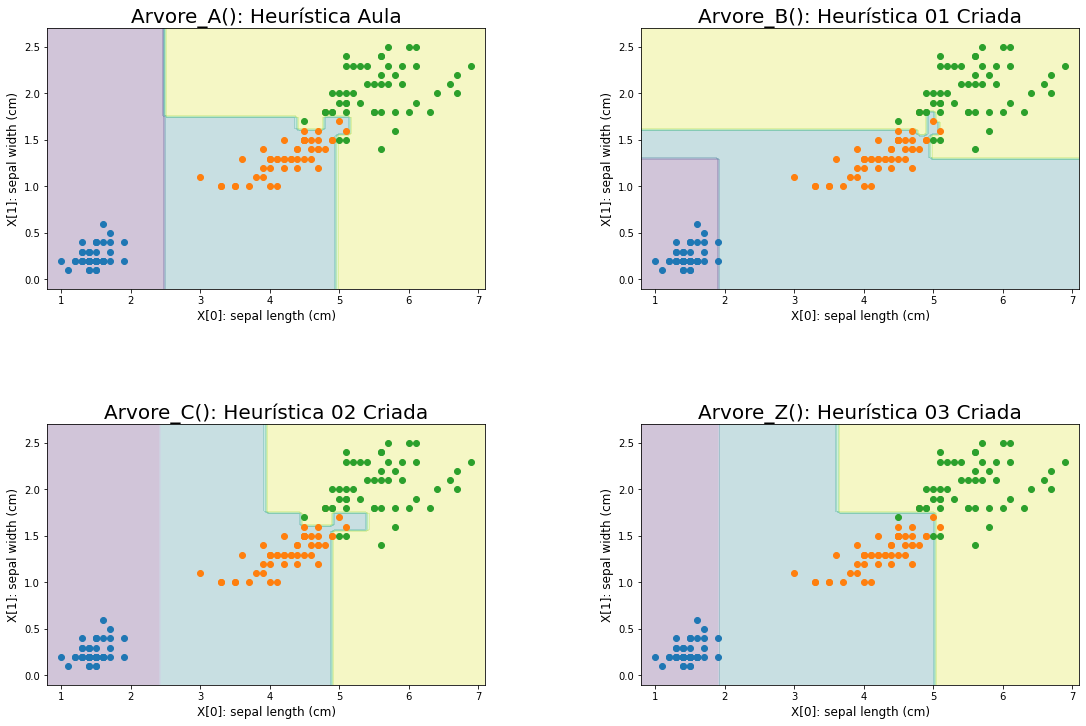

In [21]:
#---------------------------------------------------------------------------------
print('='*140)
print(' '*65,'BASE IRIS')
print('='*140)
print()

Title01 = "Arvore_A(): Heurística Aula"
Title02 = "Arvore_B(): Heurística 01 Criada"
Title03 = "Arvore_C(): Heurística 02 Criada"
Title04 = "Arvore_Z(): Heurística 03 Criada"

fig, axs = plt.subplots(2, 2, figsize=(15,10), constrained_layout=True)

plotDecisao(Arvore_A(), X, y, axs[0,0], Title01)
plotDecisao(Arvore_B(), X, y, axs[0,1], Title02)
plotDecisao(Arvore_C(), X, y, axs[1,0], Title03)
plotDecisao(Arvore_Z(), X, y, axs[1,1], Title04)

fig.set_constrained_layout_pads(w_pad=4 / 72, h_pad=4 / 72, 
                                hspace=0.2, wspace=0.2)
plt.show()

print()
print('='*140)
#---------------------------------------------------------------------------------

In [22]:
#---------------------------------------------------------------------------------
from sklearn.model_selection import cross_validate

scoresA = cross_validate(Arvore_A(), X, y, cv=10)

print('='*60)
#      ============================================================
print("                 Arvore_A: Definido na AULA                 ")
print('='*60)
print('-'*60)
print()
print("Scores:")
print(scoresA['test_score'])
print()
print("Mean =",np.mean(scoresA['test_score']))
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                 Arvore_A: Definido na AULA                 
------------------------------------------------------------

Scores:
[1.         0.93333333 1.         0.93333333 0.93333333 0.8
 0.93333333 0.93333333 1.         1.        ]

Mean = 0.9466666666666667

------------------------------------------------------------


In [23]:
#---------------------------------------------------------------------------------
scoresB = cross_validate(Arvore_B(), X, y, cv=10)

print('='*60)
#      ============================================================
print("                  Arvore_B: Heurística 01                   ")
print('='*60)
print('-'*60)
print()
print("Scores:")
print(scoresB['test_score'])
print()
print("Mean =",np.mean(scoresB['test_score']))
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                  Arvore_B: Heurística 01                   
------------------------------------------------------------

Scores:
[1.         0.93333333 1.         1.         0.93333333 0.93333333
 0.93333333 0.86666667 1.         1.        ]

Mean = 0.9600000000000002

------------------------------------------------------------


In [24]:
#---------------------------------------------------------------------------------
scoresC = cross_validate(Arvore_C(), X, y, cv=10)

print('='*60)
#      ============================================================
print("                  Arvore_C: Heurística 02                   ")
print('='*60)
print('-'*60)
print()
print("Scores:")
print(scoresC['test_score'])
print()
print("Mean =",np.mean(scoresC['test_score']))
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                  Arvore_C: Heurística 02                   
------------------------------------------------------------

Scores:
[1.         0.93333333 1.         0.93333333 0.93333333 0.93333333
 0.93333333 0.93333333 1.         1.        ]

Mean = 0.96

------------------------------------------------------------


In [25]:
#---------------------------------------------------------------------------------
scoresZ = cross_validate(Arvore_Z(), X, y, cv=10)

print('='*60)
#      ============================================================
print("                  Arvore_Z: Heurística 03                   ")
print('='*60)
print('-'*60)
print()
print("Scores:")
print(scoresZ['test_score'])
print()
print("Mean =",np.mean(scoresZ['test_score']))
print()
print('-'*60)
print('='*60)
#---------------------------------------------------------------------------------

                  Arvore_Z: Heurística 03                   
------------------------------------------------------------

Scores:
[1.         0.93333333 1.         0.93333333 0.93333333 1.
 0.93333333 1.         1.         1.        ]

Mean = 0.9733333333333334

------------------------------------------------------------


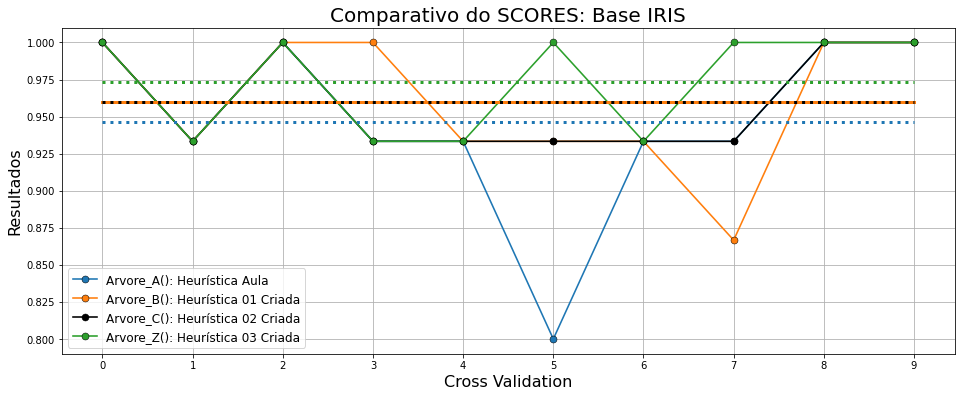

In [26]:
#---------------------------------------------------------------------------------
# GRAFICOS PARA COMPARAÇÃO
#---------------------------------------------------------------------------------
margem = 130
tamanho=(16,6)

y0 = ['0','1','2','3','4','5','6','7','8','9']

x1GP = scoresA['test_score']
x2GP = scoresB['test_score']
x3GP = scoresC['test_score']
x4GP = scoresZ['test_score']

print('='*margem)
print()
#---------------------------------------------------------------------------------
plt.figure(figsize=tamanho)

# SCORES
plt.plot(y0, x1GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='C0')
plt.plot(y0, x2GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='C1')
plt.plot(y0, x3GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='black')
plt.plot(y0, x4GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='C2')

# MEANS
plt.plot(y0,[np.mean(x1GP)]*len(y0), linewidth=3, linestyle=':', color='C0')
plt.plot(y0,[np.mean(x2GP)]*len(y0), linewidth=3, linestyle='-', color='C1')
plt.plot(y0,[np.mean(x3GP)]*len(y0), linewidth=3, linestyle=':', color='black')
plt.plot(y0,[np.mean(x4GP)]*len(y0), linewidth=3, linestyle=':', color='C2')


plt.legend(labels=[Title01, Title02, Title03, Title04], fontsize=12)
plt.title(f"Comparativo do SCORES: Base IRIS", fontsize=20)
plt.ylabel("Resultados", fontsize=16)
plt.xlabel("Cross Validation", fontsize=16)


plt.grid()
plt.show()

print()
print('='*margem)
#---------------------------------------------------------------------------------

In [27]:
#===============================================================================
#                      TABELA COM RESULTADOS
#===============================================================================
import pandas as pd

A = [Title01, Title02, Title03, Title04]
B = []

B.append(np.mean(scoresA['test_score']))
B.append(np.mean(scoresB['test_score']))
B.append(np.mean(scoresC['test_score']))
B.append(np.mean(scoresZ['test_score']))
print("="*45)
print(" "*12,"TABELA COM RESULTADOS")
print("="*45,"\n")

df = pd.DataFrame(index=A)
df['Score.Means'] = B

df
#---------------------------------------------------------------------------------

             TABELA COM RESULTADOS



,Score.Means
Arvore_A(): Heurística Aula,0.946667
Arvore_B(): Heurística 01 Criada,0.960000
Arvore_C(): Heurística 02 Criada,0.960000
Arvore_Z(): Heurística 03 Criada,0.973333


In [28]:
# ----------------------------------------------------------------------------------------------------

## Também faça comparações usando validação cruzada com pelo menos 3 bases de classificação com atributos contínuos.

### BASE01 (sklearn.datasets.load_wine)

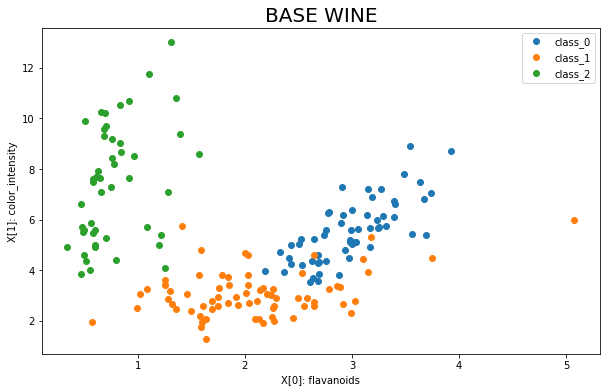

In [29]:
#---------------------------------------------------------------------------------
from sklearn.datasets import load_wine

dataset1 = load_wine()
X1, y1 = dataset1.data[:,[6,9]], dataset1.target

plt.figure(figsize=(10,6))
plt.title('BASE WINE', fontsize=20)

for k in sorted(set(y1)):
    plt.plot(X1[:,0][y1==k], X1[:,1][y1==k], "o", label=f"{dataset1.target_names[k]}")

plt.legend()
plt.xlabel(f"X[0]: {dataset1.feature_names[6]}")
plt.ylabel(f"X[1]: {dataset1.feature_names[9]}")

plt.show()
#---------------------------------------------------------------------------------

                                                                BASE WINE



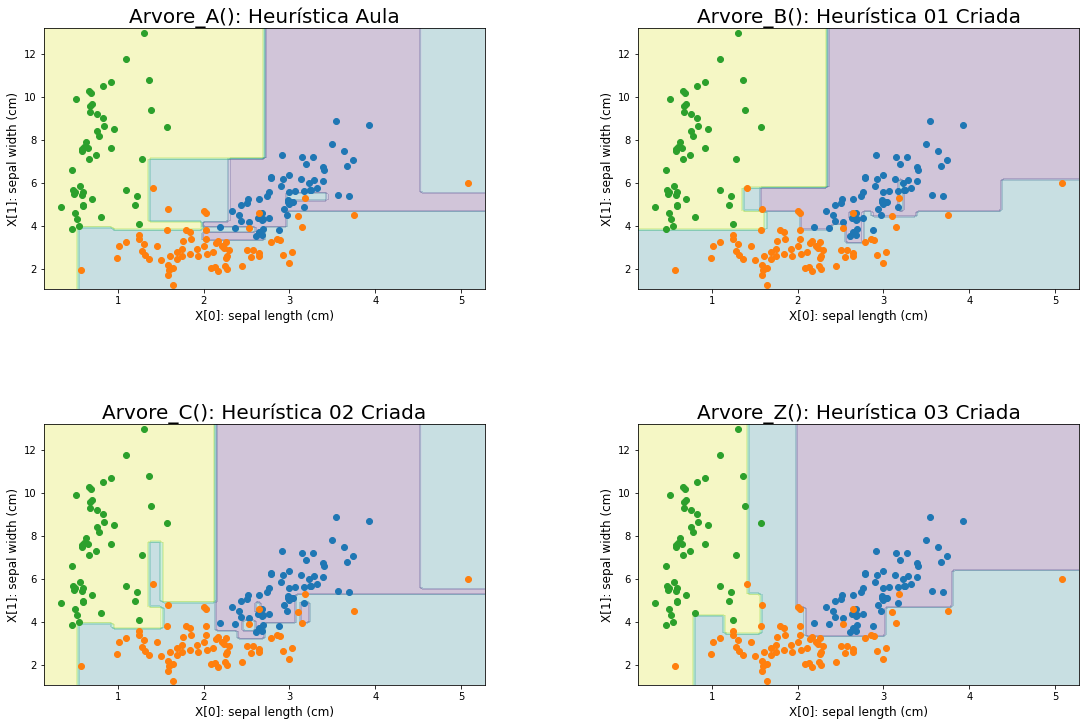

In [30]:
#---------------------------------------------------------------------------------
print('='*140)
print(' '*63,"BASE WINE")
print('='*140)
print()

fig, axs = plt.subplots(2, 2, figsize=(15,10), constrained_layout=True)

plotDecisao(Arvore_A(), X1, y1, axs[0,0], Title01)
plotDecisao(Arvore_B(), X1, y1, axs[0,1], Title02)
plotDecisao(Arvore_C(), X1, y1, axs[1,0], Title03)
plotDecisao(Arvore_Z(), X1, y1, axs[1,1], Title04)

fig.set_constrained_layout_pads(w_pad=4 / 72, h_pad=4 / 72, 
                                hspace=0.2, wspace=0.2)
plt.show()

print()
print('='*140)
#---------------------------------------------------------------------------------

In [31]:
#---------------------------------------------------------------------------------
# SCORES CROSS_VALIDADE
#---------------------------------------------------------------------------------
scoresA1 = cross_validate(Arvore_A(), X1, y1, cv=10)
scoresB1 = cross_validate(Arvore_B(), X1, y1, cv=10)
scoresC1 = cross_validate(Arvore_C(), X1, y1, cv=10)
scoresZ1 = cross_validate(Arvore_Z(), X1, y1, cv=10)
#---------------------------------------------------------------------------------

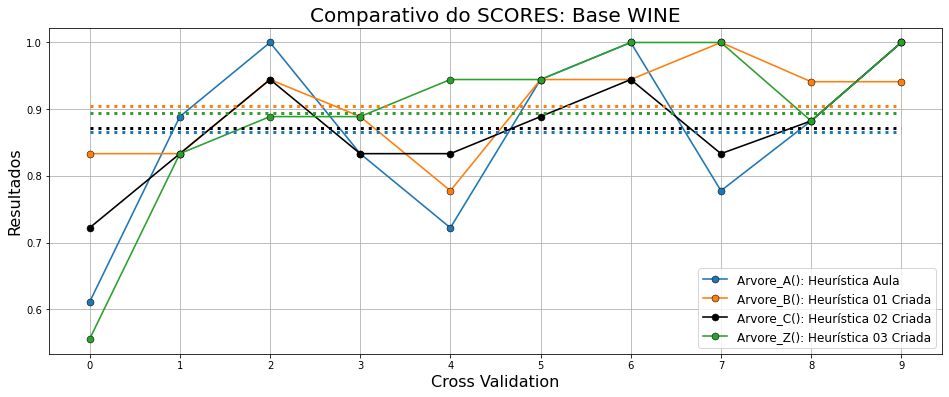

In [32]:
#---------------------------------------------------------------------------------
# GRAFICOS PARA COMPARAÇÃO
#---------------------------------------------------------------------------------
margem = 130
tamanho=(16,6)

y0 = ['0','1','2','3','4','5','6','7','8','9']

x1GP = scoresA1['test_score']
x2GP = scoresB1['test_score']
x3GP = scoresC1['test_score']
x4GP = scoresZ1['test_score']

print('='*margem)
print()
#---------------------------------------------------------------------------------
plt.figure(figsize=tamanho)

# SCORES
plt.plot(y0, x1GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='C0')
plt.plot(y0, x2GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='C1')
plt.plot(y0, x3GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='black')
plt.plot(y0, x4GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='C2')

# MEANS
plt.plot(y0,[np.mean(x1GP)]*len(y0), linewidth=3, linestyle=':', color='C0')
plt.plot(y0,[np.mean(x2GP)]*len(y0), linewidth=3, linestyle=':', color='C1')
plt.plot(y0,[np.mean(x3GP)]*len(y0), linewidth=3, linestyle=':', color='black')
plt.plot(y0,[np.mean(x4GP)]*len(y0), linewidth=3, linestyle=':', color='C2')


plt.legend(labels=[Title01, Title02, Title03, Title04], fontsize=12)
plt.title(f"Comparativo do SCORES: Base WINE", fontsize=20)
plt.ylabel("Resultados", fontsize=16)
plt.xlabel("Cross Validation", fontsize=16)


plt.grid()
plt.show()

print()
print('='*margem)
#---------------------------------------------------------------------------------

In [33]:
#===============================================================================
#                      TABELA COM RESULTADOS
#===============================================================================
C = []

C.append(np.mean(scoresA1['test_score']))
C.append(np.mean(scoresB1['test_score']))
C.append(np.mean(scoresC1['test_score']))
C.append(np.mean(scoresZ1['test_score']))
print("="*45)
print(" "*12,"TABELA COM RESULTADOS")
print("="*45,"\n")

df = pd.DataFrame(index=A)
df['Score.Means(WINE)'] = C

df
#---------------------------------------------------------------------------------

             TABELA COM RESULTADOS



,Score.Means(WINE)
Arvore_A(): Heurística Aula,0.866013
Arvore_B(): Heurística 01 Criada,0.904902
Arvore_C(): Heurística 02 Criada,0.871569
Arvore_Z(): Heurística 03 Criada,0.893791


### BASE 02 (sklearn.datasets.load_breast_cancer)

In [34]:
#---------------------------------------------------------------------------------
from sklearn.datasets import load_breast_cancer

dataset2 = load_breast_cancer()
print(dataset2.DESCR)
#---------------------------------------------------------------------------------

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

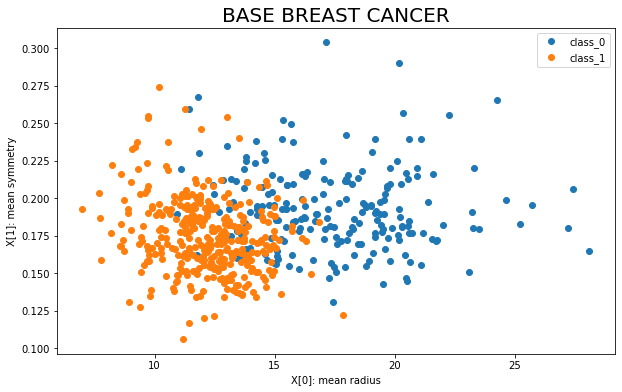

In [35]:
#---------------------------------------------------------------------------------
X2, y2 = dataset2.data[:,[0,8]], dataset2.target

plt.figure(figsize=(10,6))
plt.title('BASE BREAST CANCER', fontsize=20)

for k in sorted(set(y2)):
    plt.plot(X2[:, 0][y2==k], X2[:, 1][y2==k], 'o', label=f"{dataset1.target_names[k]}")


plt.legend()
plt.xlabel(f"X[0]: {dataset2.feature_names[0]}")
plt.ylabel(f"X[1]: {dataset2.feature_names[8]}")

plt.show()
#---------------------------------------------------------------------------------

                                                             BASE BREAST CANCER



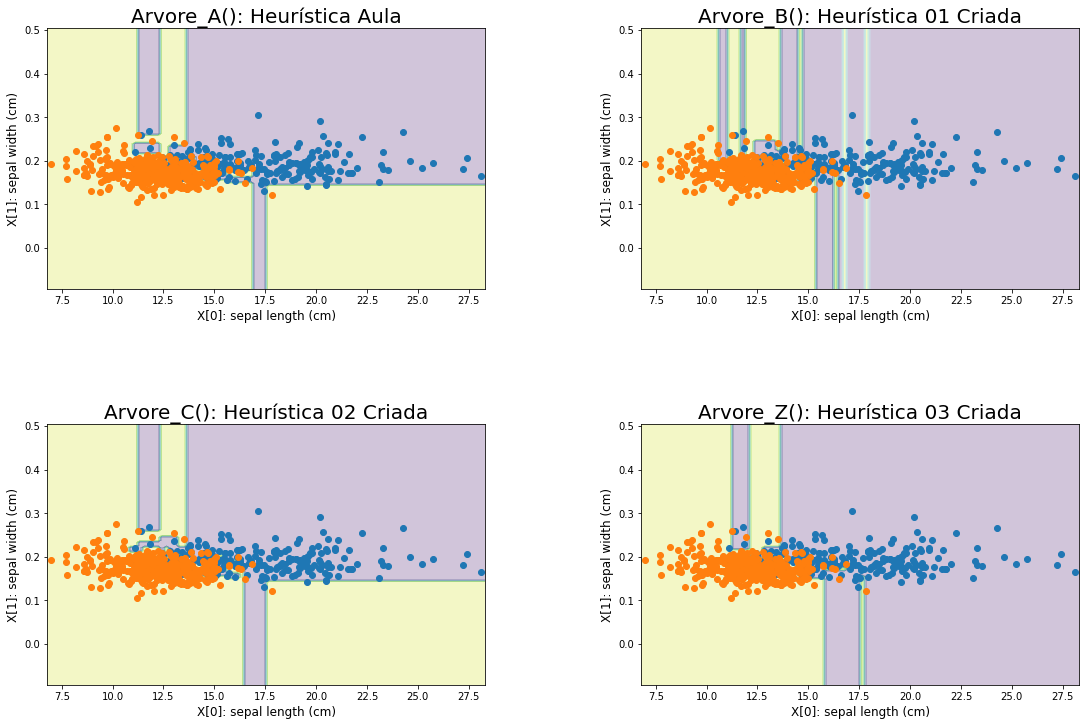

In [36]:
#---------------------------------------------------------------------------------
print('='*140)
print(' '*60,"BASE BREAST CANCER")
print('='*140)
print()

fig, axs = plt.subplots(2, 2, figsize=(15,10), constrained_layout=True)

plotDecisao(Arvore_A(), X2, y2, axs[0,0], Title01)
plotDecisao(Arvore_B(), X2, y2, axs[0,1], Title02)
plotDecisao(Arvore_C(), X2, y2, axs[1,0], Title03)
plotDecisao(Arvore_Z(), X2, y2, axs[1,1], Title04)

fig.set_constrained_layout_pads(w_pad=4 / 72, h_pad=4 / 72, 
                                hspace=0.2, wspace=0.2)
plt.show()

print()
print('='*140)
#---------------------------------------------------------------------------------

In [37]:
#---------------------------------------------------------------------------------
# SCORES CROSS_VALIDADE
#---------------------------------------------------------------------------------
scoresA2 = cross_validate(Arvore_A(), X2, y2, cv=10)
scoresB2 = cross_validate(Arvore_B(), X2, y2, cv=10)
scoresC2 = cross_validate(Arvore_C(), X2, y2, cv=10)
scoresZ2 = cross_validate(Arvore_Z(), X2, y2, cv=10)
#---------------------------------------------------------------------------------

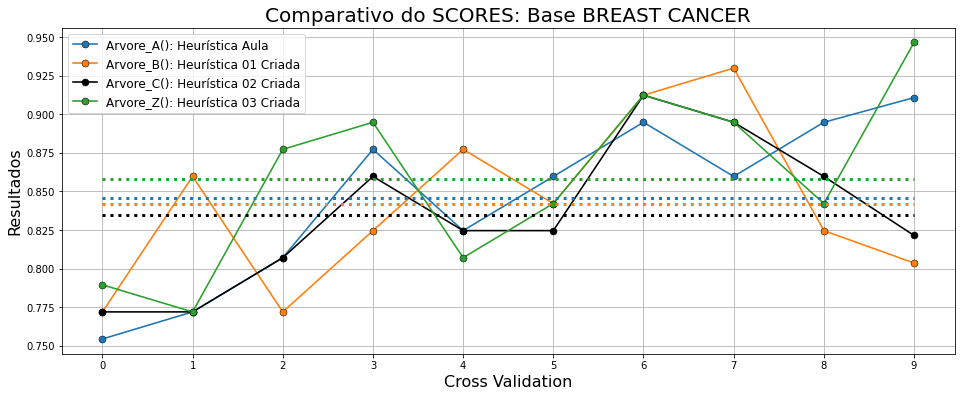

In [38]:
#---------------------------------------------------------------------------------
# GRAFICOS PARA COMPARAÇÃO
#---------------------------------------------------------------------------------
margem = 130
tamanho=(16,6)

y0 = ['0','1','2','3','4','5','6','7','8','9']

x1GP = scoresA2['test_score']
x2GP = scoresB2['test_score']
x3GP = scoresC2['test_score']
x4GP = scoresZ2['test_score']

print('='*margem)
print()
#---------------------------------------------------------------------------------
plt.figure(figsize=tamanho)

# SCORES
plt.plot(y0, x1GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='C0')
plt.plot(y0, x2GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='C1')
plt.plot(y0, x3GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='black')
plt.plot(y0, x4GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='C2')

# MEANS
plt.plot(y0,[np.mean(x1GP)]*len(y0), linewidth=3, linestyle=':', color='C0')
plt.plot(y0,[np.mean(x2GP)]*len(y0), linewidth=3, linestyle=':', color='C1')
plt.plot(y0,[np.mean(x3GP)]*len(y0), linewidth=3, linestyle=':', color='black')
plt.plot(y0,[np.mean(x4GP)]*len(y0), linewidth=3, linestyle=':', color='C2')


plt.legend(labels=[Title01, Title02, Title03, Title04], fontsize=12)
plt.title(f"Comparativo do SCORES: Base BREAST CANCER", fontsize=20)
plt.ylabel("Resultados", fontsize=16)
plt.xlabel("Cross Validation", fontsize=16)


plt.grid()
plt.show()

print()
print('='*margem)
#---------------------------------------------------------------------------------

In [39]:
#===============================================================================
#                      TABELA COM RESULTADOS
#===============================================================================
D = []

D.append(np.mean(scoresA2['test_score']))
D.append(np.mean(scoresB2['test_score']))
D.append(np.mean(scoresC2['test_score']))
D.append(np.mean(scoresZ2['test_score']))
print("="*45)
print(" "*12,"TABELA COM RESULTADOS")
print("="*45,"\n")

df = pd.DataFrame(index=A)
df['Score.Means(CANCER)'] = D

df
#---------------------------------------------------------------------------------

             TABELA COM RESULTADOS



,Score.Means(CANCER)
Arvore_A(): Heurística Aula,0.845457
Arvore_B(): Heurística 01 Criada,0.841761
Arvore_C(): Heurística 02 Criada,0.834774
Arvore_Z(): Heurística 03 Criada,0.857801


### BASE03 (sklearn.datasets.fetch_openml - WDBC)

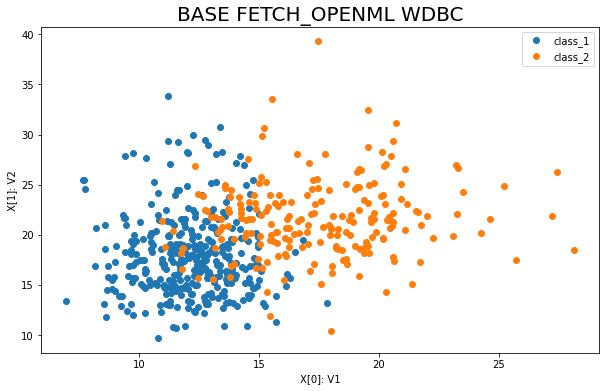

In [40]:
#---------------------------------------------------------------------------------
from sklearn.datasets import fetch_openml

# https://www.openml.org/d/1510
#
# Breast Cancer Wisconsin (Diagnostic) Data Set (WDBC). Features are computed from a digitized 
# image of a fine needle aspirate (FNA) of a breast mass.
# They describe characteristics of the cell nuclei present in the image.
# The target feature records the prognosis (benign (1) or malignant (2)).

dataset3 = fetch_openml('wdbc')
X3, y3 = dataset3.data[:,:2], np.array(dataset3.target).astype(np.int)

plt.figure(figsize=(10,6))
plt.title('BASE FETCH_OPENML WDBC', fontsize=20)

for k in sorted(set(y3)):
    plt.plot(X3[:, 0][y3==k], X3[:, 1][y3==k], 'o', label=f"{dataset1.target_names[k]}")

plt.legend()
plt.xlabel(f"X[0]: {dataset3.feature_names[0]}")
plt.ylabel(f"X[1]: {dataset3.feature_names[1]}")

plt.show()
#---------------------------------------------------------------------------------

                                                           BASE FETCH_OPENML WDBC



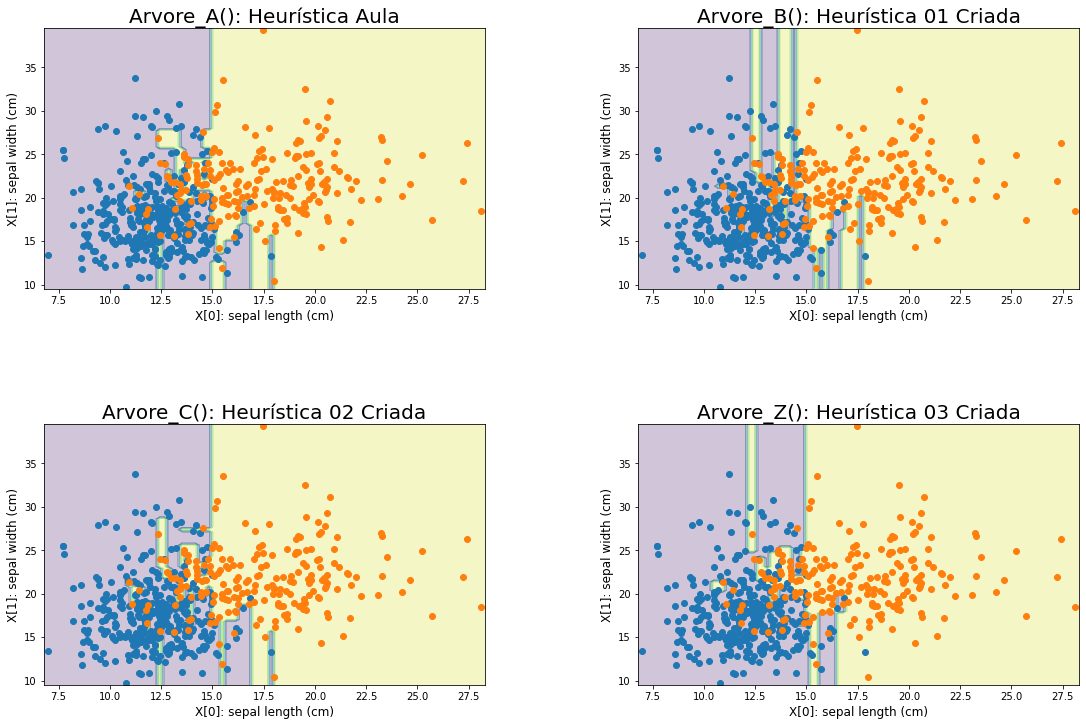

In [41]:
#---------------------------------------------------------------------------------
print('='*140)
print(' '*58,"BASE FETCH_OPENML WDBC")
print('='*140)
print()

fig, axs = plt.subplots(2, 2, figsize=(15,10), constrained_layout=True)

plotDecisao(Arvore_A(), X3, y3, axs[0,0], Title01)
plotDecisao(Arvore_B(), X3, y3, axs[0,1], Title02)
plotDecisao(Arvore_C(), X3, y3, axs[1,0], Title03)
plotDecisao(Arvore_Z(), X3, y3, axs[1,1], Title04)

fig.set_constrained_layout_pads(w_pad=4 / 72, h_pad=4 / 72, 
                                hspace=0.2, wspace=0.2)
plt.show()

print()
print('='*140)
#---------------------------------------------------------------------------------

In [42]:
#---------------------------------------------------------------------------------
# SCORES CROSS_VALIDADE
#---------------------------------------------------------------------------------
scoresA3 = cross_validate(Arvore_A(), X3, y3, cv=10)
scoresB3 = cross_validate(Arvore_B(), X3, y3, cv=10)
scoresC3 = cross_validate(Arvore_C(), X3, y3, cv=10)
scoresZ3 = cross_validate(Arvore_Z(), X3, y3, cv=10)
#---------------------------------------------------------------------------------

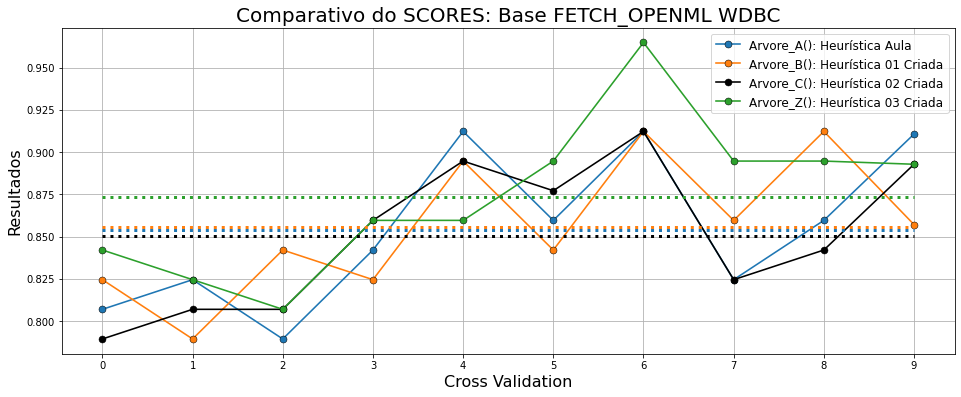

In [43]:
#---------------------------------------------------------------------------------
# GRAFICOS PARA COMPARAÇÃO
#---------------------------------------------------------------------------------
margem = 130
tamanho=(16,6)

y0 = ['0','1','2','3','4','5','6','7','8','9']

x1GP = scoresA3['test_score']
x2GP = scoresB3['test_score']
x3GP = scoresC3['test_score']
x4GP = scoresZ3['test_score']

print('='*margem)
print()
#---------------------------------------------------------------------------------
plt.figure(figsize=tamanho)

# SCORES
plt.plot(y0, x1GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='C0')
plt.plot(y0, x2GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='C1')
plt.plot(y0, x3GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='black')
plt.plot(y0, x4GP, linewidth=1.6, linestyle='-', marker='o', ms=7, markeredgecolor="black", markeredgewidth=0.5, color='C2')

# MEANS
plt.plot(y0,[np.mean(x1GP)]*len(y0), linewidth=3, linestyle=':', color='C0')
plt.plot(y0,[np.mean(x2GP)]*len(y0), linewidth=3, linestyle=':', color='C1')
plt.plot(y0,[np.mean(x3GP)]*len(y0), linewidth=3, linestyle=':', color='black')
plt.plot(y0,[np.mean(x4GP)]*len(y0), linewidth=3, linestyle=':', color='C2')


plt.legend(labels=[Title01, Title02, Title03, Title04], fontsize=12)
plt.title(f"Comparativo do SCORES: Base FETCH_OPENML WDBC", fontsize=20)
plt.ylabel("Resultados", fontsize=16)
plt.xlabel("Cross Validation", fontsize=16)


plt.grid()
plt.show()

print()
print('='*margem)
#---------------------------------------------------------------------------------

In [44]:
#===============================================================================
#                      TABELA COM RESULTADOS
#===============================================================================
E = []

E.append(np.mean(scoresA3['test_score']))
E.append(np.mean(scoresB3['test_score']))
E.append(np.mean(scoresC3['test_score']))
E.append(np.mean(scoresZ3['test_score']))
print("="*45)
print(" "*12,"TABELA COM RESULTADOS")
print("="*45,"\n")

df = pd.DataFrame(index=A)
df['Score.Means(WDBC)'] = E

df
#---------------------------------------------------------------------------------

             TABELA COM RESULTADOS



,Score.Means(WDBC)
Arvore_A(): Heurística Aula,0.854229
Arvore_B(): Heurística 01 Criada,0.855890
Arvore_C(): Heurística 02 Criada,0.850689
Arvore_Z(): Heurística 03 Criada,0.873496


In [45]:
# ----------------------------------------------------------------------------------------------------

## Escreva um parágrafo expondo sua interpretação dos resultados obtidos.

In [46]:
#===============================================================================
#                      TABELA COM RESULTADOS
#===============================================================================
print("="*68)
print(" "*15,"TABELA COM RESULTADOS - CV SCORE.MEAN")
print("="*68,"\n")

df = pd.DataFrame(index=A)
df['[IRIS]'] = B
df['[WINE]'] = C
df['[CANCER]'] = D
df['[WDBC]'] = E

df
#---------------------------------------------------------------------------------

                TABELA COM RESULTADOS - CV SCORE.MEAN



,[IRIS],[WINE],[CANCER],[WDBC]
Arvore_A(): Heurística Aula,0.946667,0.866013,0.845457,0.854229
Arvore_B(): Heurística 01 Criada,0.960000,0.904902,0.841761,0.855890
Arvore_C(): Heurística 02 Criada,0.960000,0.871569,0.834774,0.850689
Arvore_Z(): Heurística 03 Criada,0.973333,0.893791,0.857801,0.873496


Foram criadas **4 Heurísticas** distintas, contidas na: Arvore_A, Arvore_B, Arvore_C e Arvore_Z.

Para alguns exemplos (outras bases escolhidas) a Heurística demonstrada em Aula **(Arvore_A(): Heurística Aula)** teve um **resultado médio total pior**, pois ele praticamente conseguia as menores pontuações em todas as Bases testadas.

A **Heurística da Arvore_Z()** foi a que **obteve os melhores resultados** para quase todas as bases. Mas não necessáriamente ele era a melhor Heurística em todas as bases, em uma das bases (WINE) a Heurística contida na **Arvore_B()** teve um resultado melhor.

Sendo assim, o estudo do "comportamento" das bases e de como Escolher/Elaborar/Desenvolver a Heurística é de extrema importância para a conseguir os melhores resultados, pois cada uma deve ser estudada qual a heurística que melhor se adapta.

In [47]:
# ----------------------------------------------------------------------------------------------------

## FIM